In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import time
import cupy as cp


Image shape: (588, 640, 3)


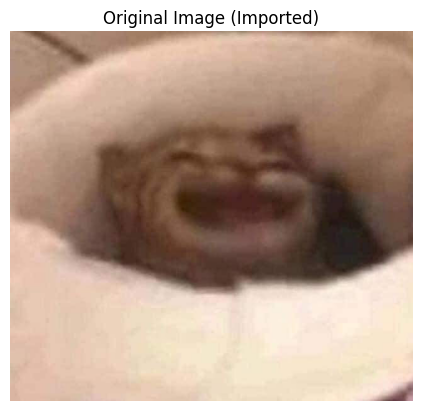

In [2]:
img = plt.imread("/content/drive/MyDrive/meme/16.jpg")
if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255.0

h, w, c = img.shape
print("Image shape:", img.shape)

plt.imshow(img)
plt.title("Original Image (Imported)")
plt.axis("off")
plt.show()

In [3]:
h, w, c = img.shape
pixels = img.reshape(-1, 3)
pixelCount = pixels.shape[0]

print("Pixel count:", pixelCount)
print("Pixels shape:", pixels.shape)
print(pixels[:5])

Pixel count: 376320
Pixels shape: (376320, 3)
[[0.76862746 0.6431373  0.56078434]
 [0.7607843  0.63529414 0.5529412 ]
 [0.7529412  0.627451   0.54509807]
 [0.7372549  0.6117647  0.5294118 ]
 [0.72156864 0.59607846 0.5137255 ]]


CPU grayscale time: 0.6259 seconds


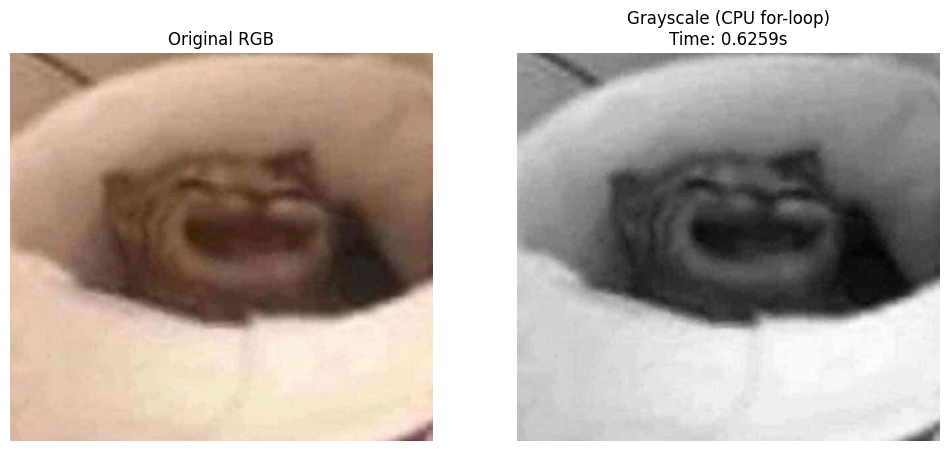

In [4]:
t0 = time.time()

gray = np.zeros(pixelCount, dtype=np.float32)
for i in range(pixelCount):
    r, g, b = pixels[i]
    # gray[i] = 0.299 * r + 0.587 * g + 0.114 * b
    gray[i] = (r + g + b) / 3

cpu_time = time.time() - t0
print(f"CPU grayscale time: {cpu_time:.4f} seconds")

gray_img = gray.reshape(h, w)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.imshow(img)
ax1.set_title("Original RGB")
ax1.axis("off")

ax2.imshow(gray_img, cmap="gray")
ax2.set_title(f"Grayscale (CPU for-loop)\nTime: {cpu_time:.4f}s")
ax2.axis("off")

plt.show()


GPU grayscale time: 0.0003 seconds


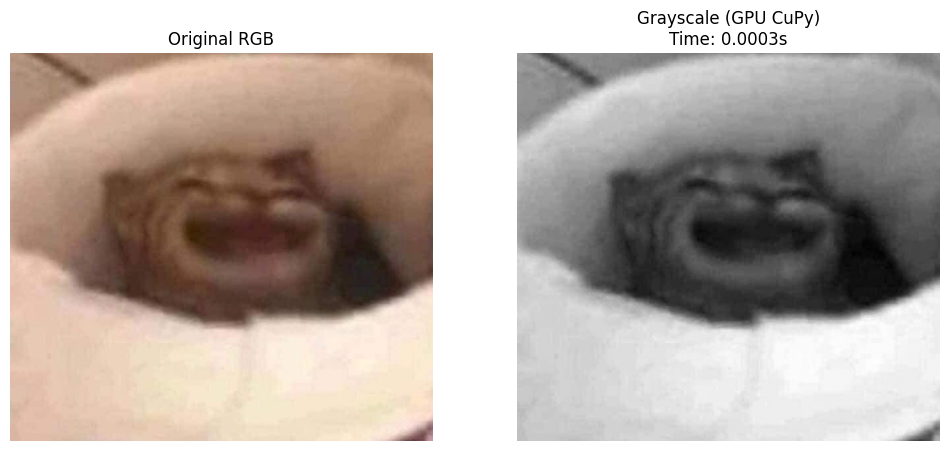

In [8]:
h, w, c = img.shape
pixelCount = h * w


flat_img = img.reshape(-1, 3)
flat_img_gpu = cp.asarray(flat_img * 255, dtype=cp.uint8)  # scale 0–255 nếu ảnh float
gray_gpu = cp.empty(pixelCount, dtype=cp.uint8)


kernel = cp.RawKernel(r'''
extern "C" __global__
void rgb2gray(const unsigned char* img, unsigned char* gray, int total_pixel) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < total_pixel) {
        int idx = i * 3;
        unsigned char r = img[idx];
        unsigned char g = img[idx + 1];
        unsigned char b = img[idx + 2];
        gray[i] = (r + g + b) / 3;
    }
}
''', 'rgb2gray')


threadsperblock = 256
blockspergrid = (pixelCount + threadsperblock - 1) // threadsperblock


t0 = time.time()
kernel((blockspergrid,), (threadsperblock,), (flat_img_gpu, gray_gpu, pixelCount))
cp.cuda.Stream.null.synchronize()
gpu_time = time.time() - t0
print(f"GPU grayscale time: {gpu_time:.4f} seconds")


gray_result = cp.asnumpy(gray_gpu).reshape(h, w)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(img)
ax1.set_title("Original RGB")
ax1.axis("off")

ax2.imshow(gray_result, cmap="gray")
ax2.set_title(f"Grayscale (GPU CuPy)\nTime: {gpu_time:.4f}s")
ax2.axis("off")

plt.show()
